In [2]:
import os
import urllib.request
from timeit import timeit
import sklearn
from sklearn.datasets import load_iris, make_blobs, fetch_openml, load_digits
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import FixedLocator, FixedFormatter

#To make the notebook's output stabel across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path to saving images
IMAGE_PATH = os.path.join("images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, fig_extension="png", tight_layout=True, resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure,", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Most applications of Machine Learning today are based on supervised learning, yet the vast majority of the available data is unlabeled: **we have input feature X, but we don't have the labels y.** Therefore, there is a huge potential in unsupervised learning.

Labeling data requires human experts to go through all the data, which is long costly and tedious task, even for a small subset from of a large dataset. Thus the labeled dataset will quite small, resulting in a poor performance from a classifier. Additionally, every time a company makes any changes to its products, the whole process will need to be started from scratch. 

**Unsupervised learning aims to exploit the unlabeled data without needing humans to label every instance in the dataset/subset.**

Dimensionality reduction is one of the common tasks for unsupervised learning and was discussed in a previous notebook. Thus, we'll focus on a few more unsupervised learning tasks and algorithms:
- **Clustering**
    - The goal is to group similar instacnes together into _clusters_. Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction and more.

- **Anomaly detection**
    - The objective is to learn what "normal" data looks like, and then use that to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

- **Density estimation**
    - This is the task of estimating the _probabilty density function_ (PDF) of the random process that generated the dataset. Density estimation is commonly used for anomaly detection: instances that are located in very low-dimensional regions are more likely to be anomalies. It's also useful for data analysis and visualization.

We'll look at **clustering** first, using K-Means and DBSCAN. Then, discuss Gaussian mixture models and see how they can be used for density estimation, clustering and anomaly detection

# Section: Clustering

***Clustering*** is a task that identifies similar instances and assigning them to _clusters_ or groups of similar instances. It's just like classification, but clustering is an **unsupervised task.** 

In the following figure (figure 9-1), **on the left** is the iris dataset, where each instance's species is represented with a different marker. It's a labeled dataset, so classfication algorithms such as Logistic Regression, SVMs or Random Forest classfiers are well suited.

**On the righ** is the same dataset, but without labels, thus classifications algorithms are of no use. This is where clustering algorithms comes in, many of them can easily detect the lower-left cluster. 

The dataset has two additional features (sepal length and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well - when we use Gaussian mixture model, only 5/150 are assigned to the wrong cluster (96.66% success rate).

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure, Unsupervised Learning Techniques - Classification vs clustering


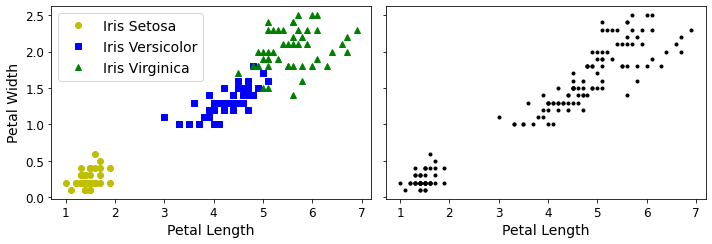

Figure 9-1


In [4]:
plt.figure(figsize=(10, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris Virginica")
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal Width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal Length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("Unsupervised Learning Techniques - Classification vs clustering")
plt.show()
print("Figure 9-1")

    - A Gaussian mixture model can help separate these clusters pretty well using all 4 features: petal length and width, and sepal length and width

In [5]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

    - Let's map each cluster to a class. We'll pick the most common class for each cluster (using the scipy.stats.mode() function)

In [6]:
mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id]) #"_" ignores a value when unpacking
    mapping[mode[0]] = class_id
mapping

{1: 0, 2: 1, 0: 2}

In [7]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

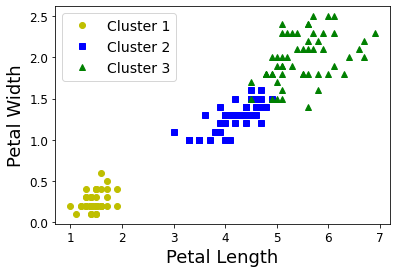

In [8]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal Length", fontsize=18)
plt.ylabel("Petal Width", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()

    - Check how many right prediction we got

In [9]:
np.sum(y_pred == y)

145

In [10]:
np.sum(y_pred == y) / len(y)

0.9666666666666667

**Applications that use clustering inculde:**

- **Customer segmentation**
    - Clustering customers based on their purchases and their activity on a website. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. For instance, it can be useful in _recommender systems_ to suggest content that other users in the same cluster enjoyed.
    
    
- **Data analysis**
    - When analyzing a new dataset, it can be helpful to run a clustering algorithm, and then analyze each cluster separately
    
    
- **As a dimensionality reduction technique**
    - Once a dataset has been clustered, it's usually possible to measure each instance's _affinity_ with each cluster (_affinity_ is any measure of how will an instance fits into a cluster). Each instances' feature vector $x$ can be replaced with the vector of its clusters affinities. If there a re $k$ clusters, then this vector is $k$ dimnesional. This vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing
    
    
- **Anomaly detection (also called outlier detection)**
    - Any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual request per second. Anomaly detection is paritcularly useful in detecting defects in manufacturing or fraud detection
    
    
- **Semi-supervised learning**
    - If there are only a few labels available, it's possible to perform clustering and propogate the labels to all the instances in the same cluster. This technique can greatly increase the number of labels available for subsequent supervised learning algorithm, thus improving performance
    
    
- **Search engines**
    - Some search engines allow you to search for images that are similar to a reference image. To build such a system, first apply a clustering algorithm to all the images in the database - similar images would end up in the same cluster. Then when a user provides a reference image, use the trained clustering model to find this image's cluster, and then you can return all the images from this cluster
    
    
- **To segment an image**
    - By clustering pixels according to their color, then replacing each pixel's color with the mean color of the cluster, it's possible to considerably reduce the number of different colors in the image. Image segmentation is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object
    

A cluster depends on the context, and different algorithms will capture different kinds of clusters. For examples, algorithms that look for instances centered around a particular point, called _centroid_. Others look for continuous regions of densely packed instances: these clusters can take on any shape

## K-Means

In the following figure 9-2, its clear that there are 5 blobs of instances. The k-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often with just a few iterations. K-Means is sometimes referred to as Lloyd-Forgy, because it was published by two different people from different places

In [11]:
blob_centers = np.array([
    [ 0.2,  2.3],
    [-1.5 ,  2.3],
    [-2.8,  1.8],
    [-2.8,  2.8],
    [-2.8,  1.3]
])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [12]:
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                 random_state=7)

Saving figure, Clustering - KMeans, Unlabeled dataset of 5 blobs


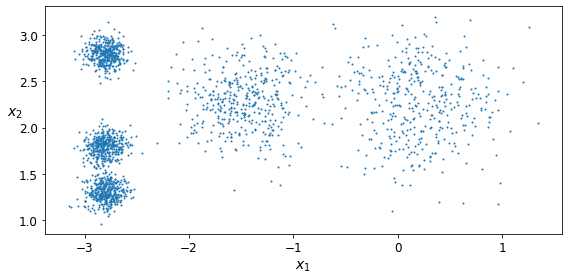

Figure 9-2


In [13]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", rotation=0, fontsize=14)

plt.figure(figsize=(8,4))
plot_clusters(X)
save_fig("Clustering - KMeans, Unlabeled dataset of 5 blobs")
plt.show()
print("Figure 9-2")

    - Fit and predict by using the KMeans on this dataset. It will try to find each blob's center and assign each instance to the closest blob

**Note** specifying the number of clusters is generally not that easy.

In [14]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

    - Each instances has been assigned to one of the 5 clusters

In [15]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

**Note** in Kmeans, the ***label*** of an instance is the **_index_ of the cluster it gets assigned to**

In [16]:
y_pred is kmeans.labels_

True

    - Estimation of the 5 centroids

In [17]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

    - Predict labels of new instances

In [18]:
X_new = np.array([
    [0, 2],
    [3, 2],
    [-3, 3],
    [-3, 2.5]
])
kmeans.predict(X_new)

array([1, 1, 2, 2])

    - Let's plot the cluster's decision boundries (gives a Voronoi diagram)

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker="o", s=35, linewidths=8, 
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=2, linewidths=12,
               color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,
            color="k")
    
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
        
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0, fontsize=14)
    else:
        plt.tick_params(labelleft=False)

<ipython-input-19-50808b416ee9>:22: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,


Saving figure, Clustering - KMeans, decision boundaries


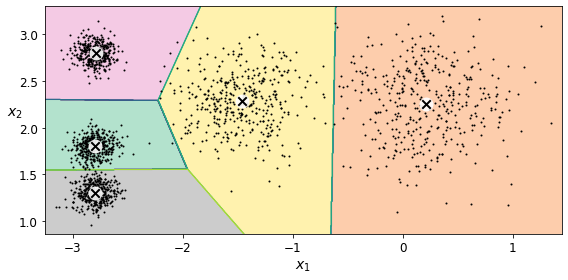

Figure 9-3


In [20]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("Clustering - KMeans, decision boundaries")
plt.show()
print("Figure 9-3")

The vast majority of the instances were clearly assigned to the appropriate cluster, but a few instance were probably mislabeled (especially near the boundary between the top-left cluster and the central cluster). 

When the blobs vary in diameters, K-Means doesn't perform that well because all it care about when assigning instances to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, called ***hard clustering***, it cab be useful to give each instance a score per cluster, called ***soft clustering***.

The score can be the distance between the instance and the centroid, or the similarity score (or affinity), such as the Gaussian Radial Bases Function (RBF). 

In KMeans, the ***transform()*** method measures the distance from each instance to every centroid

In [21]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

We can verify this by calculating the Euclidian distance between each instance and each centroid

In [22]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k ,2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

Recall that X_new has 4 instances and 5 clusters. We can see that the first instances distance from the first cluster is 2.81, on the second cluster it's 0.32 and so on.

If you have a high-dimensional dataset and you transform it this way, you end up with $k$-dimensional dataset: this transformation can be a very **efficient nonlinear dimnesionality reduction technique.**

### The K-Means algorithm

How does the algorithm work?
- First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
- Repeat until convergance (that is, until the centroids stop moving):
    - Assign each instance to the closest centroid
    - Update the centroids to be the mean of the instances that are assigned to them

> The computational complexity of the algorithm is generally linear with regard to the number of instances $m$, the number of clusters $k$, and the number of dimensions $n$. **However**, this is only true when the data has a clustering structure. If it doesn't, then in the worst-case scenario the complexity can increase exponentially with the number of instances. In practice this rarely happens, and K-Means is generally one of the fastest clustering algorithms

The Kmeans class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), set ***init="random"***, ***n_init=1*** and ***algorithm="full"***

In the following figure 9-4, the centroids are initialized randomly (top left), then the instances are labeled (top right), and so on. After 3 iterations, the algorithm has reached a clustering that seems fairly resonable

In [23]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full",
                     max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full",
                     max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full",
                     max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

<ipython-input-19-50808b416ee9>:22: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,


KeyboardInterrupt: 

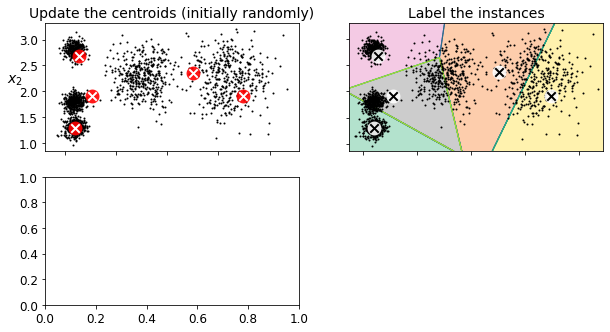

In [24]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0, fontsize=14)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("Clustering - KMeans, the algorithm")
plt.show()
print("Figure 9-4")

###### K-Means variability

In the original K-Means algorithm, the centroids are initialized randomly, and the algorithm runs a single iteration to gradually improve the centroids.

However, one major problem with this approach is that if you rub K-Means multiple times (or with different random seed), it can converge to very different solutions:

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)
    
    plt.figure(figsize=(10, 3.2))
    
    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)
        
    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X)
    if title2:
        plt.title(title2, fontsize=14)

In [ ]:
kmneans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                           algorithm="full", random_state=2)
kmneans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                           algorithm="full", random_state=5)
plot_clusterer_comparison(kmneans_rnd_init1, kmneans_rnd_init2, X, 
                          title1="Solution 1", 
                          title2="Solution 2 (with different random int")

##### Inertia

To select the best model, we'll need a way to evaluate a K-Means model's performance. Unfortunately, clustering is an unsupervised task, so we don't have the targets. But at least we can measure the distance between each instance and their corresponding centroid. This is the idea behind ***inertia*** metric:

In [ ]:
kmeans.inertia_

**Inertia is the sum of the squared distance between an instance and its closests centroid**. We can verify it in the following way:

In [ ]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

The **score()** method **returns the negative inertia**. Why negative? it's because a predictor's **score()** method must always repect the ""greater is better" rule

In [ ]:
kmeans.score(X)

##### Multiple initializations

**One approach to solve the variability issue is to run the k-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.** For example, let's look at the inertia of the last two "bad" models in the previous model:

In [ ]:
kmneans_rnd_init1.inertia_

In [ ]:
kmneans_rnd_init2.inertia_

_kmneans_rnd_init1_ and _kmneans_rnd_init2_ have higher inertia than the first "good" model _kmeans_, which means that they're probably worse

Setting **n_init** hyperparameter will make Scikit Learn run the original algorithm **n_init** times, and selects the solution that reduces the inertia. By default, **n_init=10**

In [ ]:
kmeans_rnd_10_init = KMeans(n_clusters=5, init= "random", n_init=10,
                           algorithm="full", random_state=2)
kmeans_rnd_10_init.fit(X)

In the following plot, we'll see that we ended up with the initial model, which is the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$)

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_init, X)

Let's have a look at a few ways in which it's possible to mitigate this risk by improving the centroid initialization

##### Centroid initialization methods, K-Means++

Instead of initializing the centroids randomly, it's preferable to initialize thme using the following algorithm (proposed by David Arthur and Segei Vassilvitskii)
- Take one centroid $c_l$ chosen uniformely at random from the dataset.
- Take a new cetner $c_i$, choosing and instance $x_1$ with probability: $D(x_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}^{(j)})}^2$, where $D(x_i)$ is the distance between the instance $x_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are father away from already chosen centorids are much more likely to be selected as centroids.
- Repeat the previous steps until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialzation, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it's possible to reduce **n_init** considerably. Most of the time, this largely compenstates for the additional complexity of the initialization process

To set the initialization to K-Means++, set **init=k-means++** (default)

In [ ]:
KMeans()

In [ ]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

##### Accelerated K-Means and mini-batch K-Means

**Accelerated K-Means**
- The K-Means algorithm can be significantly accelerated by avoiding unnecessary distance calculations: This is achieved by exploiting the triangle inequality (i.e, that a straight line is always the shortest distance between two points) and by keeping track of lower and upper bounds for distances between instances and centorids.

To use Elkan's variant of K-Means, set **algorithm="elkan"**. Note, it doesn't support sparse data, so by default, Scikit Learn uses "elkan" for dense data and "full"(the regular K-Means algorithm) for sparse data.

In [ ]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

In [ ]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

**Mini-batch K-Means**
- The algorithm is capable of using mini-bathces, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of 3 or 4 and makes it possible to cluster huge datasets that don't fit in memory.

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

In [ ]:
minibatch_kmeans.inertia_

If the data doesn't fit in memory, the simplest option is to use the **memmap** class (like in Incremental PCA)

In [ ]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"],
                                                   random_state=42)

Next, we write it to a **memmap**

In [ ]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mm[:] = X_train

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

If the data is too large thus can't use **memmap**, things get more complicated. Let's start by loading the next bath (in real life, the data would be loaded from disk)

In [ ]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now train the model by feeding it one batch at a time. Also, implement multiple initializations and keep the model with the lowest inertia

In [ ]:
np.random.seed(42)

In [ ]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500 #More data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
        
    if (best_kmeans is None or
       minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [ ]:
best_kmeans.score(X)

Mini-batch K-Means is much faster than regular K-Means

In [ ]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

In [ ]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

It's suppose to be faster, in our case it wasn't. It's performance is often lower (higher inertia), and it keeps degrading as $k$ increases.

Let's plot the inertia ratio and the training ratio between Mini-batch KMeans and regular KMeans

In [ ]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=14)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0 ,100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=14)
plt.title("Training time (sec)", fontsize=14)
plt.axis([1, 100, 0 ,6])

save_fig("Clustering - KMeans and mini-batch inertias and time ")
plt.show()
print("Figure 9-6")

From figure 9-6, we can see on the left that as the **number of clusters(k) increases, Mini-batch K-Means inertia increases as well (worse inertia) - compared to regular K-Mneas.** Yet on the righ, **Mini-batch K-Means is much faster than K-Means.**

##### Finding the optimal number of clusters

**Approach #1**: Up until now we set the number of clusters $k$ to 5, because from a glance we knew that it was the correct number. Yet, we won't always have an easy time knowing the number of clusters, and setting the wrong value might give a bad model

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("Clustering - KMeans, bad choices for number of clusters")
plt.show()
print("Figure 9-7")

The models above don't look too great. We can check the inertias of both models and choose the lowest one

In [ ]:
kmeans_k3.inertia_

In [ ]:
kmeans_k8.inertia_

The inertia for $k=3$ is 653.21, which is higher than for $k=5$. But with $k=8$ it's just 119.11. The **inertia isn't a good performance mertic when trying to choose $k$ because it keeps getting lower as we increase $k$.**

Indeed, the more clusters there are, the closer each instance will be to its closest centroid, therefore, the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
               for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
inertias[3]

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.annotate("Elbow", xy=(4, inertias[3]), xytext=(0.55, 0.55),
             textcoords="figure fraction", fontsize=16, 
             arrowprops=dict(facecolor="black", shrink=0.1))
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 1300])
save_fig("Clustering - KMeans, inertia vs number of clusters")
plt.show()
print("Figure 9-8")

There is an elbow at $k=4$ - less clusters is bad while more clusters wouldn't help and we might just be splitting good clusters in half for no good reason.

Using this example, having $k=4$ isn't perfect because it means that the two blobs on the lower left will be considered as a single cluster. Nonetheless, it's still a good clustering

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

**Approach #2**: Figuring out the number of clusters with the aforementioned technique is somewhat crude. A more precise approach (but more computationally expensive) is to use the ***silhouette score***, which is the mean ***silhouette coefficient*** over all the instances.

An instances silhouette coefficient is equal to $(b-a) / max(a, b)$, where:
- $a$ is the mean distance to the other instances in the same cluster (the _intra-cluster distance_)
- $b$ is the _mean nearest-cluster distance_ that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster)

The silhouette coefficient can vary between -1 to +1:
- A coefficient close to +1 means that the instance is well inside its own cluster and far from other cluster
- A coefficient close to 0 means that it's close to a cluster boundary
- A coefficient close to -1 means that the instance may have been assigned to the wrong cluster

Let's plot the silhouette score as a function of $k$:

In [ ]:
silhouette_score(X, kmeans.labels_)

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette scores", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("Clustering - KMeans, silhouette scores vs number of clusters")
plt.show()
print("Figure 9-9")

The figure is much richer than the previous one; in particular, although it confirms that $k=4$ is a good choce, it also shows that $k=5$ is quite good as well

To get an even more informative visualization, we can use the **silhoutette diagram** to plot every instance's silhouette coefficient sorted by the cluster they're assigned to and by the value of the coefficient

In [ ]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k-2)
    
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette coefficients")
    else:
        plt.tick_params(labelbottom=False)
    
    plt.axvline(x=silhouette_scores[k-2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
    
save_fig("Clustering - KMeans, silhouette diagramss analysis")
plt.show()
print("Figure 9-10")

In the figure above, each diagram contains one knife shape per cluster. The **height** indicates the **number of instances** the cluster has, and its **width** represents the **sorted silhouette coefficients of the instances in the cluster (wider is better).** The **dashed line indicates the mean silhouette coefficient (mean silhouettescore).**

We can see that $k=5$ is the best option, because all of the clusters are roughly the same size and they all cross the dashed line

## Limits of the K-Means

K-Means limits include the following:
- Run the algorithm several times to avoid suboptimal solutions
- Specify the number of clusters
- Isn't optimized to handle clusters of varying size, different densities or nonspherical shapes

Let's see how K-Means deals with a dataset containing 3 ellipsoidal clusters of different dimensions, densities and orientations

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                    n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)                    
kmeans_bad.fit(X)

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("Clustering - KMeans, limits of KMeans")
plt.show()
print("Figure 9-11")

Evidently, we can't use any of the solutions. **The model on left plot**, is better but still chops off 25% of the middle cluster and assigns it to the cluster in the right, **The model on the right plot** is even worse, even though its inertia is lower.

On these types of elliptical clusters, **Gaussian mixture models work better**.

> It's important to scale the input features before runnung K-Means, or the clusters may be very stretched and K-Means will perform poorly. Scaling doesn't gurantee that all clusters will be spherical, but it generally improves things

## Using clustering for image segmentation

**Image segmentation** is the task of partitioning an image into multiple segments. In **semantic segmentation**, all pixels that are part of the same object type get assigned to the same segment. 

For instance, in self driving car's vision system, pixels that represent a pedestrian's image might go to the "pedestrian" segment.

In **instance segmentation**, all pixels that are part of the same individual object are assgined to the same segment. In this case, there would be a different segment for each pedestrian.

In this section, we'll be using **color segmentation**. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be sufficient. For example, analyzing satellite images to measure how much total forest area there is in a region.

In [ ]:
filename = "Ladybug.png"
image = imread(os.path.join(IMAGE_PATH, filename))
image.shape

The image is represented as a 3D array: Where 533=**height**, 800=**width** and 3=**number of color channels (RGB)**.

The following code reshapes the array to get a long list of RGB colors, then it clusters these colors using K-Means. Next, for each color, it looks for the mean color of the pixel's color cluster. For examples, all shades of green may be replaced with the same light green color. Finally, it reshapes this long list of colors to get the same shape as the original image

In [ ]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [ ]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis("off")

save_fig("Clustering - KMeans, Image segmentation using color clusters")
plt.show()
print("Figure 9-12")

From the figure 9-12 we see that if fewer than 8 clusters is used, the ladybugs red color fails to get a cluster of its own - it merges with the environment. 

This is because K-Means prefers clusters of similar sizes. The ladybug is small, thus even though it has a distinct color, K-Means fail to dedicate a cluster to it

## Using clustering for preprocessing

Clustering is an efficient approach to dimensionality reduction, specially for a preprocessing step before a supervised learning algorithm

In [27]:
X_digits, y_digits = load_digits(return_X_y=True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits,
                                                    random_state=42)

In [29]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000,
                            random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [30]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

So the baseline is 96.88% accuracy. Let's use K-Means as the preprocessing step. We'll create a pipeline that will cluster the training set into 50 clusters and replace the images with their distances to these 50 clusters, then apply Logistic Regression

In [31]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs",
                                   max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [32]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

How much did the error rate drop?

In [33]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

We managed to reduce the error rate from 3.12% to 2.23% (that's a 28.57% reduction between Logistic Regression alone and K-Means and Logistic Regression together)

But we chose the number of clusters $k$ completely arbitrarily, we can use GridSearchCV to find the best value for $k$ that results the best classification performance. 

This is possible because K-Means is just a **preprocessing step** in a classification pipeline, finding a good value for $k$ is simpler that earlier: there's no need for silhouette analysis or minimize the inertia.

In [34]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   2.3s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.4s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.5s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.0s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.3s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.4s
[CV] END ..............................kmeans__n_clusters=39; total time=   2.5s
[CV] END ..............................kmeans__n_clusters=39; total time=   2.6s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=70; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=70; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=70; total time=   3.4s
[CV] END ..............................kmeans__n_clusters=71; total time=   2.7s
[CV] END ..............................kmeans__n_clusters=71; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=71; total time=   3.3s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.1s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.0s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=73; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=73; total time=   3.2s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [35]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [36]:
grid_clf.score(X_test, y_test)

0.9844444444444445

With $k$=88 clusters, we got an accuracy boost, reaching 98.22$ accuracy on the test set

## Using clustering for semi-supervised learning

We can use clustering in semi-supervised learning when we have plenty of unlabeled instances and very few labeled instances

In [37]:
n_labeled = 50

In [38]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                 random_state=42)
log_reg_semi.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(multi_class='ovr', random_state=42)

In [39]:
log_reg_semi.score(X_test, y_test)

0.8333333333333334

It's not as high as with the other models. Let's see if we can do better by clustering the training set to 50 clusters, then for each cluster, find the image closest to the centroid. We'll call this iamges the **representative images**

In [40]:
k = 50

In [41]:
kmeans_semi = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans_semi.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Let's plot the images and label them manually

Saving figure, Clustering - KMeans, Semi-supervised learning with digits


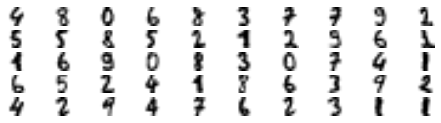

Figure 9-13


In [42]:
plt.figure(figsize=(8, 2))

for i, digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, i + 1 )
    plt.imshow(digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis("off")

save_fig("Clustering - KMeans, Semi-supervised learning with digits", tight_layout=False)
plt.show()
print("Figure 9-13")

Let's look at each image and manually label it

In [43]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [44]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1
])

Now there's a dataset with 50 labeled instances, but instead of completely being random, each of them is a representative image of its cluster. Let's see if the performance is better

In [46]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                  max_iter=5000, random_state=42)
log_reg_semi.fit(X_representative_digits, y_representative_digits)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [47]:
log_reg_semi.score(X_test, y_test)

0.9222222222222223

That's good news, from 83.3% accuracy to 92.2%, although the training is only been done on 50 instances. Since its costly to manually label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances

Next, ***label propogation*** should be a good idea. That is, propogating the labels to all the other instances that are in the same cluster

In [52]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans_semi.labels_==i] = y_representative_digits[i]

In [56]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                  max_iter=5000, random_state=42)
log_reg_semi.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [57]:
log_reg_semi.score(X_test, y_test)

0.9333333333333333

A reasonable accuracy boost. We should probably had propagated the labels only to instances closest to the centroid, because by propagating to the whole cluster, we have clearly mislabeled instances close to the boundries of the cluster.

Let's propagate the labels to the 75th percentile closest to the centroid

In [58]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans_semi.labels_]
for i in range(k):
    in_cluster = (kmeans_semi.labels_==i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist> cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [59]:
partially_propogated = (X_cluster_dist != -1)
X_train_partially_propogated = X_train[partially_propogated]
y_train_partially_propogated = y_train_propagated[partially_propogated]

In [60]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                 max_iter=5000, random_state=42)
log_reg_semi.fit(X_train_partially_propogated, y_train_partially_propogated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [61]:
log_reg_semi.score(X_test, y_test)

0.9355555555555556

The score is a bit better than before (93.33%). With just 50 labeled instances 
(just 5 examples per class on average), we got 93.35% performance, which is getting closer to the performace of Logistic Regression on the fully labeled digits dataset (96.88%).

This is because the propagated labels are actually pretty good. their accuracy is close to 97%

In [62]:
np.mean(y_train_partially_propogated == y_train[partially_propogated])

0.9750747756729811

## D